# Image Clustering Using NimbusML Pipeline

NimbusML implements TensorFlowScorer that allows to use pretrained deep neural net models as featurizers. Users can use any intermediate output as the transform of image pixel values. 

In this example, we develop a clustering model using NimbusML pipeline to group images into 10 groups (clusters). The images are downloaded from Wikipedia Commons and English Wikipedia. For more details about the images, please refer to [readme](https://express-tlcresources.azureedge.net/datasets/DogBreedsVsFruits/README.html). The image files are loaded with NimbusML image loader and processed with pretrained TensorFlow (https://www.tensorflow.org/) deep neural net (DNN) model (e.g. Inception V3) for the feature extraction.

## Note: 
The user needs to download the Alexnet tensorflow model from __[here](http://jaina.cs.ucdavis.edu/datasets/adv/imagenet/alexnet_frozen.pb)__ and extract the "alexnet_frozen.pb" and put it in the same directory as the notebook.

## Preparing Data

The image loader of NimbusML uses as input a column from a pandas dataframe that indicates the full path to the image. Therefore, the user needs to prepare a csv/tsv file that includes the path information. For classification, the label should be in the same file.

In [1]:
import os
import pandas as pd
import numpy as np
import math
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from io import BytesIO
from nimbusml import Pipeline
from nimbusml.feature_extraction.image import Loader, Resizer, PixelExtractor
from nimbusml.preprocessing import TensorFlowScorer
from nimbusml.decomposition import PcaTransformer
from nimbusml.preprocessing.schema import ColumnDropper
from nimbusml.cluster import KMeansPlusPlus

In [2]:
# Load image summary data from github
url = "https://express-tlcresources.azureedge.net/datasets/DogBreedsVsFruits/DogFruitWiki.SHUF.117KB.735-rows.tsv"
df_train = pd.read_csv(url, sep = "\t", nrows = 100)
df_train['ImagePath_full'] = "https://express-tlcresources.azureedge.net/datasets/DogBreedsVsFruits/" + \
                         df_train['ImagePath']
df_train.head()

,Label,Title,Url,ImagePath,ImagePath_full
0,dog,Bearded Collie,https://upload.wikimedia.org/wikipedia/commons...,images\dog\Bearded_Collie_600.jpg,https://express-tlcresources.azureedge.net/dat...
1,fruit,Muntries,https://upload.wikimedia.org/wikipedia/commons...,images\fruit\1200px-Kunzea_pomifera_flowers.jpg,https://express-tlcresources.azureedge.net/dat...
2,dog,Griffon Nivernais,https://upload.wikimedia.org/wikipedia/commons...,images\dog\Griffon_nivernais.jpg,https://express-tlcresources.azureedge.net/dat...
3,fruit,Ziziphus,https://upload.wikimedia.org/wikipedia/commons...,images\fruit\1200px-Zizyphus_zizyphus_Ypey54.jpg,https://express-tlcresources.azureedge.net/dat...
4,fruit,Papaya,https://upload.wikimedia.org/wikipedia/commons...,images\fruit\Carica_papaya_-_Köhler–s_Medizina...,https://express-tlcresources.azureedge.net/dat...


In [3]:
# Download images from url, save to local image_temp folder, update the full path to local directory
base_path = os.path.join(os.getcwd(),"image_temp") 
base_path_dog = os.path.join(base_path,"images","dog")
base_path_fruit = os.path.join(base_path,"images","fruit")

for path in [base_path,base_path_dog, base_path_fruit]:
    if not os.path.exists(path):
        os.makedirs(path)

for _,row in df_train.iterrows():
    try:
        response = requests.get(row["ImagePath_full"])
        Image.open(BytesIO(response.content)).save(os.path.join(base_path,row["ImagePath"]))
        df_train.loc[_,'ImagePath'] = os.path.join(base_path,row["ImagePath"])
        if _%20 == 0:
            print("Dowloading " + str(_) + "/" + str(len(df_train)) + " images...")
    except:
        df_train.drop(_)
df_train.head()
print("Done")

Dowloading 0/100 images...
Dowloading 20/100 images...
Dowloading 40/100 images...
Dowloading 60/100 images...
Dowloading 80/100 images...
Done


The "ImagePath" column that includes the full image path can be passed to the NimbusML image loader.

## Training Model

In order to extract image features using the deep learning model, four transformations are needed.
          1. Loader: load the image files from the "ImgPath" column of the input file
          2. Resizer: as the pretrained DNN model uses an image with width and height 299, we need to resize the image
          3. PixelExtractor: we need to extract the image tensor from the image to numeric features
          4. TensorFlowScorer: apply the DNN model to the extracted features. 

In [6]:
loader = Loader(columns = {'Placeholder':'ImagePath'}) # columns = {output_col_name:input_col_name}
resizer = Resizer(image_width=227, 
                  image_height=227, 
                  columns = ['Placeholder'])  # equivalent to columns = {'Placeholder':'Placeholder'}
pix_extractor = PixelExtractor(columns = ['Placeholder'],
                               interleave = True)
dnn_featurizer = TensorFlowScorer(
                                  model_location=r'alexnet_frozen.pb',
                                  columns={'Relu_1': 'Placeholder'}
                                  )
drop_input = ColumnDropper(columns = ['Placeholder'])

We create a pipeline that only has those transformations to see constructed image features.

In [7]:
ppl1 = Pipeline([loader, resizer, pix_extractor, dnn_featurizer, drop_input])
transformed = ppl1.fit_transform(df_train) 
transformed.head()

,Label,Title,Url,ImagePath,ImagePath_full,Relu_1.0,Relu_1.1,Relu_1.2,Relu_1.3,Relu_1.4,...,Relu_1.4086,Relu_1.4087,Relu_1.4088,Relu_1.4089,Relu_1.4090,Relu_1.4091,Relu_1.4092,Relu_1.4093,Relu_1.4094,Relu_1.4095
0,dog,Bearded Collie,https://upload.wikimedia.org/wikipedia/commons...,C:\Users\v-tshuan\Programs\NimbusML-Samples\sa...,https://express-tlcresources.azureedge.net/dat...,0.0,0.000000,0.000000,1.420249,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,fruit,Muntries,https://upload.wikimedia.org/wikipedia/commons...,C:\Users\v-tshuan\Programs\NimbusML-Samples\sa...,https://express-tlcresources.azureedge.net/dat...,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,3.416956,0.0,0.0,0.464706,0.000000,0.000000,0.0,0.0,0.0
2,dog,Griffon Nivernais,https://upload.wikimedia.org/wikipedia/commons...,C:\Users\v-tshuan\Programs\NimbusML-Samples\sa...,https://express-tlcresources.azureedge.net/dat...,0.0,0.088755,0.811384,0.000000,0.0,...,2.170286,0.000000,0.0,0.0,0.000000,0.000000,1.110376,0.0,0.0,0.0
3,fruit,Ziziphus,https://upload.wikimedia.org/wikipedia/commons...,C:\Users\v-tshuan\Programs\NimbusML-Samples\sa...,https://express-tlcresources.azureedge.net/dat...,0.0,1.692611,0.000000,0.000000,0.0,...,0.000000,1.000454,0.0,0.0,0.000000,9.258146,0.000000,0.0,0.0,0.0
4,fruit,Papaya,https://upload.wikimedia.org/wikipedia/commons...,C:\Users\v-tshuan\Programs\NimbusML-Samples\sa...,https://express-tlcresources.azureedge.net/dat...,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.523427,1.542979,0.000000,0.0,0.0,0.0


We can see that, for each image, 1000 (for 'Softmax') features were extracted. We then create a full pipeline with the kmeans clustering learner at the end.

In [8]:
# Creating full pipeline
pca = PcaTransformer(rank = 600, columns = ['Relu_1']) # Add PCA to reduce dimensionality 
kmeansplusplus = KMeansPlusPlus(n_clusters = 10, feature = ['Relu_1'], number_of_threads = 1)

ppl = Pipeline([loader, resizer, pix_extractor, dnn_featurizer, pca, kmeansplusplus]) 

Notice that for clustering methods, no label is needed. However, in NimbusML, the users are required to input a label column. Therefore, we use the 'class' column from the input data. This input is not used in the algorithm. #TODO: delete this part once the bug is fixed.

In [ ]:
# Training pipeline
ppl.fit(df_train) #no y label should be required, need support serires

# Generating clustering result
result = ppl.predict(df_train);

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Initializing centroids
Centroids initialized, starting main trainer
Model trained successfully on 100 instances
Not training a calibrator because it is not needed.
Elapsed time: 00:01:19.8572341


The predicted cluster and the scores for each cluster are generated with the .predict() function.

In [8]:
result.head()

,PredictedLabel,Score.0,Score.1,Score.2,Score.3,Score.4,Score.5,Score.6,Score.7,Score.8,Score.9
0,9,48.715694,196.892700,176.272949,39.086586,196.296570,89.849045,180.898560,93.460846,42.809196,31.105650
1,5,110.141663,133.176605,81.525513,111.708939,145.776947,53.723076,174.292114,83.029350,75.193245,81.721832
2,0,16.016426,200.293549,212.317123,91.493248,233.072662,108.143402,246.047821,143.894958,101.994789,78.159943
3,1,323.128021,57.072067,224.685852,310.462097,201.771286,189.325775,309.505157,206.023773,302.829773,244.442841
4,7,116.025093,91.397224,123.987152,80.798065,151.489105,62.102425,115.235840,43.938499,62.096260,54.576447


## Evaluation

We evaluate the clustering performance using the Dunn index (DI). A high DI indicates a set of compact clusters with small variance within clusters and long distances from clusters to clusters. It is calculated as the ratio of the minimum inter-cluster distance and the maximum diameter of a cluster, i.e. the maximum distance for the farthest two points inside the same cluster.

In [9]:
# plot clustering results
def plotClusters(results, df_train, label_name, plot_cluster_nums):
    figure_count = 0
    for plot_cluster_num in plot_cluster_nums:
        print("Cluster " + str(plot_cluster_num))
        image_files = list(df_train.loc[results[label_name] == plot_cluster_num]['ImagePath'])
        n_row = math.floor(math.sqrt(len(image_files)))
        n_col = math.ceil(len(image_files)/n_row)
        fig = plt.figure(figure_count)
        fig.canvas.set_window_title(str(plot_cluster_num))
        for i in range(len(image_files)):
            plt.subplot(n_row, n_col, i+1)
            plt.axis('off')
            plt.imshow(mpimg.imread(image_files[i]))
        figure_count += 1
        plt.show()

# computes the maximum pairwise distance within a cluster
def intraclusterDist(cluster_values):
    max_dist = 0.0 
    for i in range(len(cluster_values)):
        for j in range(len(cluster_values)):
            dist = np.linalg.norm(cluster_values[i]-cluster_values[j])
            if dist > max_dist:
                max_dist = dist
    return max_dist

# compute Dunn Index for the clustering results
def computeDunnIndex(features, labels, n_clusters):  
    cluster_centers = [np.mean(features.loc[labels == i]) for i in range(n_clusters)]
    index = float('inf')  
    max_intra_dist = 0.0
    # find maximum intracluster distance across all clusters
    for i in range(len(cluster_centers)):
        cluster_values = np.array(features.loc[labels == i])
        intracluster_d = float(intraclusterDist(cluster_values))
        if intracluster_d > max_intra_dist:
            max_intra_dist = intracluster_d

    # perform minimization of ratio
    for i in range(len(cluster_centers)):
        inner_min = float('inf')
        for j in range(len(cluster_centers)):
            if i != j:
                intercluster_d = float(np.linalg.norm(cluster_centers[i]-cluster_centers[j]))
                ratio = intercluster_d/max_intra_dist
                if ratio < inner_min:
                    inner_min = ratio
        if inner_min < index:
            index = inner_min
    return index, pd.DataFrame(cluster_centers)

In [10]:
# Compute the Dunn Index on the clustering results (omitting the first
# four columns because they contain text labels and filenames).
DI2, cluster_centers = computeDunnIndex(transformed.iloc[:,5:4098], result['PredictedLabel'], 10)
print('Dunn Index Value: ' + str(round(DI2,2)))

Dunn Index Value: 0.25


Cluster 1


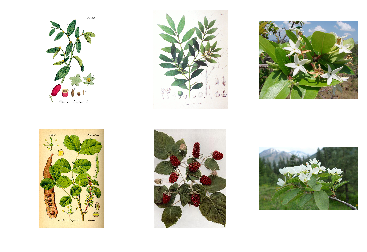

Cluster 2


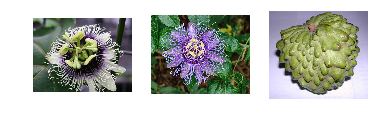

Cluster 3


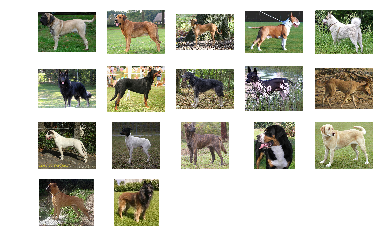

In [11]:
# We plot three clusters with ids 1, 2 and 3 from the result.
plotClusters(result, df_train, 'PredictedLabel', [1,2,3])

### Cluster Center

In this section, we visualize the cluster centers in a 2D plane,

In [12]:
# Dimensional reduction to 2D array using PCA
cluster_centers_2 = PcaTransformer(rank = 2, center = False, \
                                   columns = {'pca':list(cluster_centers.columns)}).fit_transform(cluster_centers)
cluster_centers_2

,Relu_1.0,Relu_1.1,Relu_1.10,Relu_1.100,Relu_1.1000,Relu_1.1001,Relu_1.1002,Relu_1.1003,Relu_1.1004,Relu_1.1005,...,Relu_1.991,Relu_1.992,Relu_1.993,Relu_1.994,Relu_1.995,Relu_1.996,Relu_1.997,Relu_1.998,pca.0,pca.1
0,0.000000,0.770278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.127736,...,0.000000,0.000000,0.241895,0.000000,0.000000,0.000000,0.000000,2.464712,58.028538,-25.203957
1,0.228809,0.901769,0.000000,0.000000,0.000000,1.039454,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.291523,0.000000,0.061099,0.000000,2.449302,0.000000,0.040497,64.011467,21.972214
2,0.000000,1.417163,0.000000,0.000000,0.000000,0.000000,2.992362,0.954273,3.689380,0.000000,...,0.000000,2.057017,0.000000,0.000000,0.000000,0.041073,0.000000,2.484595,57.588615,23.309061
3,0.696920,0.345958,1.290344,0.000000,0.000000,0.096300,0.392115,0.361147,0.556113,1.252363,...,0.527576,0.857266,0.366822,0.148124,0.089877,0.069620,0.000000,4.311934,44.485729,-16.087826
4,0.000000,2.992896,0.000000,0.000000,0.000000,0.631954,0.000000,0.000000,0.271308,0.000000,...,0.000000,1.466947,0.430880,0.000000,0.000000,0.088744,0.000000,3.349486,51.239796,61.413853
5,0.645710,0.385184,0.239119,0.070293,0.000000,0.502116,0.755390,1.064302,0.000000,0.061806,...,0.001848,0.459876,0.218065,0.125919,0.391552,0.167139,0.149729,1.965848,47.304817,1.525293
6,0.021455,0.000000,0.000000,0.000000,0.000000,5.803978,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.148099,0.131280,0.223501,0.000000,0.000000,0.000000,0.000000,50.060257,-44.289791
7,0.776750,0.000000,0.000000,0.000000,0.155621,1.924262,0.753425,0.167777,0.000000,0.206684,...,0.000000,0.576076,0.000000,0.051706,0.152729,0.226890,0.000000,0.898393,40.932320,-12.638844
8,0.135691,0.077364,0.000000,0.000000,0.000000,0.250649,0.274890,0.031139,0.402118,1.666890,...,1.217962,1.767914,0.107368,0.798248,0.000000,0.000000,0.000000,1.263315,41.468811,-16.915419
9,0.547199,0.698203,0.446988,0.035139,0.035749,0.741727,0.048929,0.119037,0.629345,1.212344,...,0.483827,0.637361,0.027065,0.006085,0.003015,0.901033,0.000000,0.818498,36.079082,-10.916731


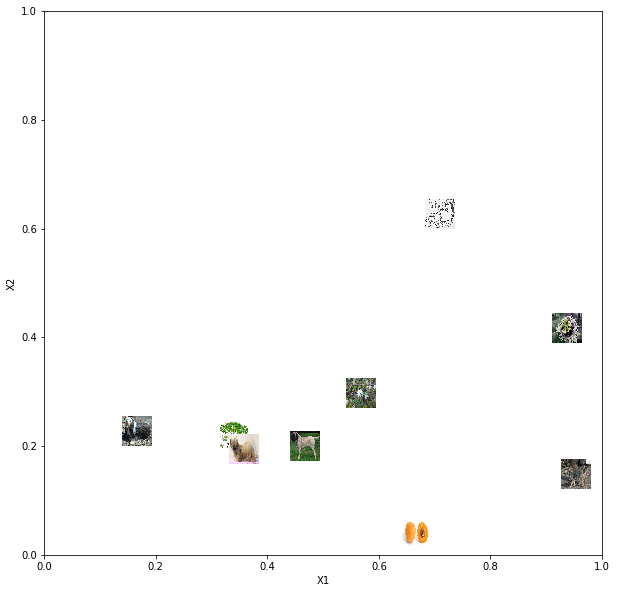

In [13]:
# Visualize
fig = plt.figure(1,figsize=(10,10))
plt.xlabel("X1")
plt.ylabel("X2")
for i in range(10):
    file_name = df_train['ImagePath'][np.argwhere(result['PredictedLabel'] == i)[0][0]]
    image = np.array(Image.open(file_name).resize((30,30)))
    figs = fig.figimage(image, (cluster_centers_2['pca.0'][i] - 30) * 20,(cluster_centers_2['pca.1'][i] + 60) * 3 )
    figs.set_zorder(20)
plt.show();